## Описание задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО "Так закаляем сталь" решил уменьшить потребление электроэнергии на этапе обработки стали. Требуется построить модель, которая предскажет температуру стали перед переходом на следующий этап обработки

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.  
Из сплава выводится сера (десульфация), добавлением примесей корректируется состав и отбираются пробы. Сталь легируют – изменяют её состав – подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат.  
Перед тем, как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют лигирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.  
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.

### Описание данных
- data_arc.csv – данные об электродах;
- data_bulk.csv – данные о подаче сыпучих материалов (объём);
- data_bulk_time.csv – данные о подаче сыпучих материалов (время);
- data_gas.csv – данные о продувке сплава газом;
- data_temp.csv – данные измерения температуры;
- data_wire.csv – данные о проволочных материалах (объём);
- data_wire_time.csv – данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

### Содержание
- [1 Исследовательский анализ данных](#step1)
- [2 Подготовка данных для обучения моделей](#step2)
- [3 Обучение и тестирование моделей](#step3)
- [4 Вывод](#step4)

### 1 Исследовательский анализ данных<a id="step1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from lightgbm.sklearn import LGBMRegressor

from tqdm.notebook import tqdm

#### Загрузка данных

In [2]:
# Загрузка данных с предварительным преобразованием к временным типам
try:
    data_arc = pd.read_csv('data_arc.csv', parse_dates=[1, 2])
    data_bulk = pd.read_csv('data_bulk.csv')
    data_bulk_time = pd.read_csv('data_bulk_time.csv', parse_dates=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
    data_gas = pd.read_csv('data_gas.csv')
    data_temp = pd.read_csv('data_temp.csv', parse_dates=[1])
    data_wire = pd.read_csv('data_wire.csv')
    data_wire_time = pd.read_csv('data_wire_time.csv', parse_dates=[1, 2, 3, 4, 5, 6, 7, 8, 9])
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv', parse_dates=[1, 2])
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv', parse_dates=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv', parse_dates=[1])
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv', parse_dates=[1, 2, 3, 4, 5, 6, 7, 8, 9])

#### Исследование и предобработка данных об электродах

In [3]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


***Количество партий***

In [5]:
data_arc.key.unique().size

3214

##### Графическое представление данных об активной мощности на электродах

In [6]:
# определим функцию data_plotter, представляющую данные графически
def data_plotter(data, column_name, x_label):
    fig, ax = plt.subplots(2, 1, sharex=True)
    ax = ax.flat
    ax[0].hist(data[column_name], bins=30)
    ax[0].set_title('Гистограмма распределения значений столбца "%s"' % column_name)
    ax[0].grid(True)

    ax[1].boxplot(data[data[column_name].notna()][column_name], vert=False)
    ax[1].set_title('Распределение значений значений столбца "%s"' % column_name)
    ax[1].set_xlabel(x_label)
    ax[1].set_yticklabels('')
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

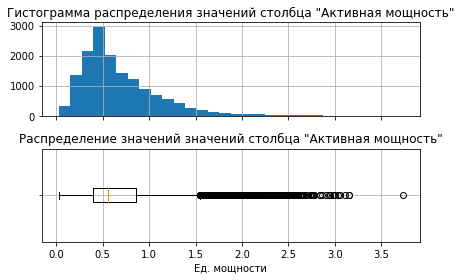

In [7]:
data_plotter(data=data_arc, column_name='Активная мощность', x_label='Ед. мощности')

**Вывод:** аномальных данных не обнаружено

##### Графическое представление данных о реактивной мощности на электродах

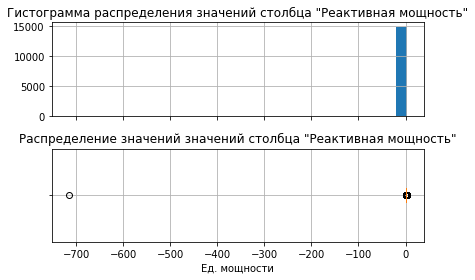

In [8]:
data_plotter(data=data_arc, column_name='Реактивная мощность', x_label='Ед. мощности')

**Вывод:** обнаружено аномальное значение в данных 

In [9]:
# Определение индекса аномальной строки
anomaly_ind = data_arc.loc[data_arc['Реактивная мощность'] < -700].index.values.tolist()[0]

In [10]:
# Определение значения активной мощности в строке
power = data_arc.loc[anomaly_ind, 'Активная мощность']

In [11]:
# Отображение значений индекса аномальной строки и соответствующего значения активной мощности
anomaly_ind, power

(9780, 0.4957824945)

In [12]:
# Отображение соседних строк вокруг аномальной
data_arc.loc[anomaly_ind-1:anomaly_ind+1]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


In [13]:
# Замена аномального значения реактивной мощности будет осуществляться через вычисление медианного
# значения в наборе данных ближайших значениий активной мощности
repl = (data_arc
            .query('`Активная мощность` > @power - 0.01 and `Активная мощность` < @power + 0.01')['Реактивная мощность']
            .median()
       )
repl

0.36203575134999993

In [14]:
# Произведение замены
data_arc.loc[anomaly_ind, 'Реактивная мощность'] = repl

##### Графическое представление исправленных данных о реактивной мощности на электродах

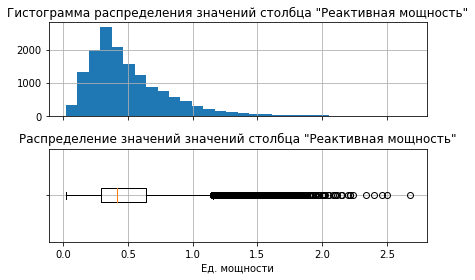

In [15]:
data_plotter(data=data_arc, column_name='Реактивная мощность', x_label='Ед. мощности')

**Вывод**: данные очищены

##### Исследование корреляции в данных между активной и реактивной мощностями на электродах

In [16]:
data_arc['Активная мощность'].corr(data_arc['Реактивная мощность'])

0.9631823749772016

**Вывод:** данные активной и реактивной мощностей сильно коррелированы (прямопропорционально), это значит, что в качестве фичей можно оставить лишь один из двух столбцов во избежание избыточности признаков

#### Исследование данных о подаче сыпучих материалов (объём)

In [17]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [18]:
# Замена пробелов в названиях столбцов
data_bulk.columns = ['_'.join(col.split()) for col in data_bulk.columns]

In [19]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk_1   252 non-null    float64
 2   Bulk_2   22 non-null     float64
 3   Bulk_3   1298 non-null   float64
 4   Bulk_4   1014 non-null   float64
 5   Bulk_5   77 non-null     float64
 6   Bulk_6   576 non-null    float64
 7   Bulk_7   25 non-null     float64
 8   Bulk_8   1 non-null      float64
 9   Bulk_9   19 non-null     float64
 10  Bulk_10  176 non-null    float64
 11  Bulk_11  177 non-null    float64
 12  Bulk_12  2450 non-null   float64
 13  Bulk_13  18 non-null     float64
 14  Bulk_14  2806 non-null   float64
 15  Bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


##### Графическое представление данных о подаче сыпучих материалов

In [20]:
# Определим вторую функцию data_plotter_2, графически отображающую распределение множественных признаков
def data_plotter_2(data, shape, figsize):
    fig, ax = plt.subplots(*shape, figsize=figsize)
    ax = ax.flat
    for i, col in enumerate(data.columns[1:]):
        ax[i].hist(data[col])
        ax[i].set_title(col)
        ax[i].grid(True)

    plt.tight_layout()
    plt.show()

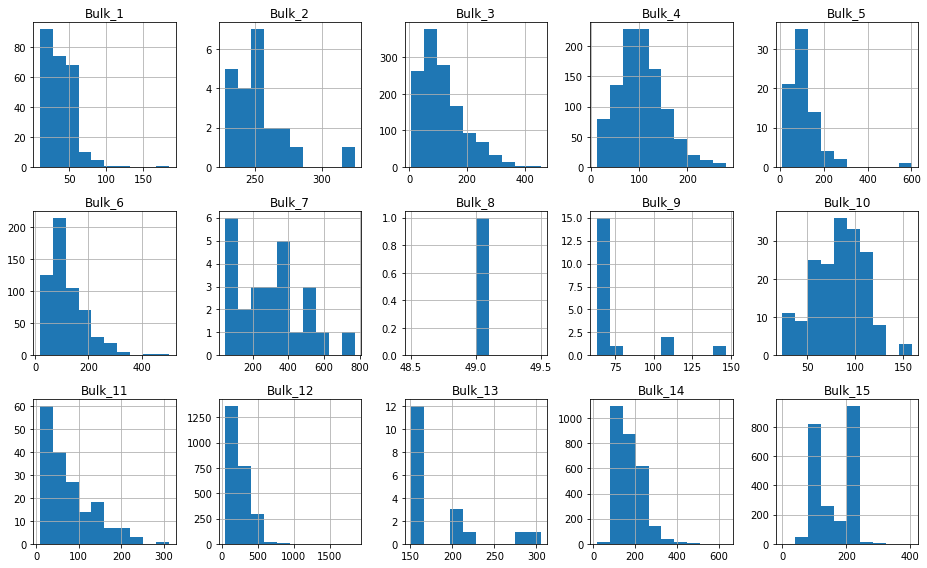

In [21]:
data_plotter_2(data=data_bulk, shape=(3, 5), figsize=(13, 8))

**Вывод:** аномальных данных не обнаружено

##### Замена пропусков в данных о подаче сыпучих материалов
Пропуски в данных можно расценивать как отсутствие подачи соответствующих сыпучих материалов, поэтому правомочно заменить пропуски нулями

In [22]:
data_bulk = data_bulk.fillna(0).astype(int)

#### Исследование данных о подаче сыпучих материалов (время)

In [23]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56


In [24]:
data_bulk_time.columns = ['_'.join(col.split()) for col in data_bulk_time.columns]

In [25]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk_1   252 non-null    datetime64[ns]
 2   Bulk_2   22 non-null     datetime64[ns]
 3   Bulk_3   1298 non-null   datetime64[ns]
 4   Bulk_4   1014 non-null   datetime64[ns]
 5   Bulk_5   77 non-null     datetime64[ns]
 6   Bulk_6   576 non-null    datetime64[ns]
 7   Bulk_7   25 non-null     datetime64[ns]
 8   Bulk_8   1 non-null      datetime64[ns]
 9   Bulk_9   19 non-null     datetime64[ns]
 10  Bulk_10  176 non-null    datetime64[ns]
 11  Bulk_11  177 non-null    datetime64[ns]
 12  Bulk_12  2450 non-null   datetime64[ns]
 13  Bulk_13  18 non-null     datetime64[ns]
 14  Bulk_14  2806 non-null   datetime64[ns]
 15  Bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


**Вывод:** аномальных данных не обнаружено, пропуски в данных можно трактовать, как отсутствие подачи соответствующих сыпучих материалов, заполнять временные пропуски не нужно

#### Исследование данных о подаче газа

In [26]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [27]:
data_gas.columns = ['_'.join(col.split()) for col in data_gas.columns]

In [28]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


##### Графическое представление данных о подаче газа

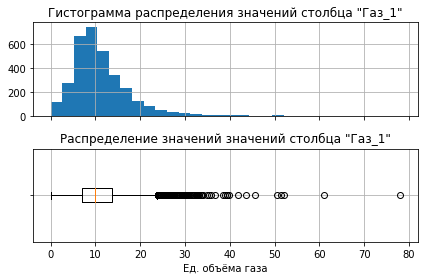

In [29]:
data_plotter(data=data_gas, column_name='Газ_1', x_label='Ед. объёма газа')

**Вывод:** аномальных данных не обнаружено

#### Исследование данных о проволочных материалах (объём)

In [30]:
data_wire.head(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
data_wire.columns = ['_'.join(col.split()) for col in data_wire.columns]

In [32]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire_1  3055 non-null   float64
 2   Wire_2  1079 non-null   float64
 3   Wire_3  63 non-null     float64
 4   Wire_4  14 non-null     float64
 5   Wire_5  1 non-null      float64
 6   Wire_6  73 non-null     float64
 7   Wire_7  11 non-null     float64
 8   Wire_8  19 non-null     float64
 9   Wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


##### Графическое представление данных о проволочных материалах

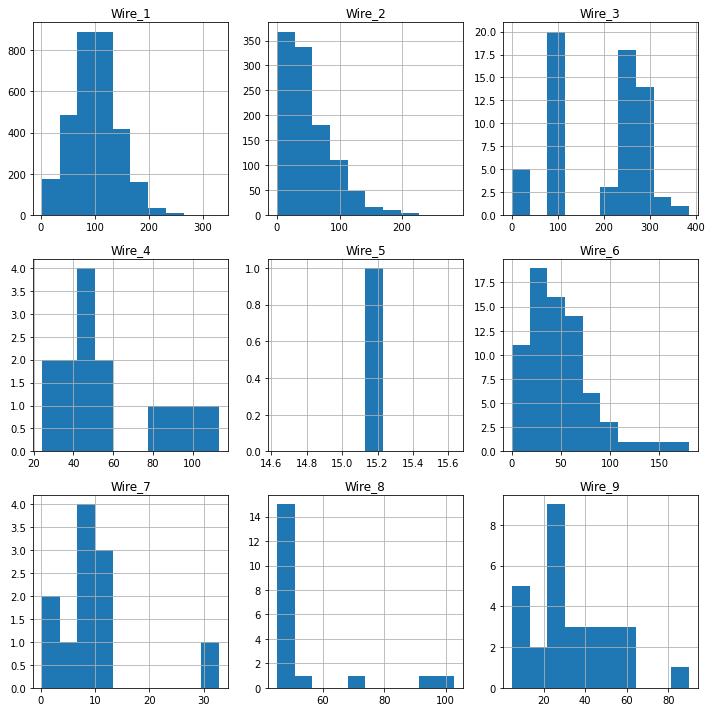

In [33]:
data_plotter_2(data=data_wire, shape=(3, 3), figsize=(10, 10))

**Вывод:** аномальных данных не обнаружено

##### Замена пропусков в данных о проволочных материалах
Пропуски в данных можно расценивать как отсутствие подачи соответствующих проволочных материалов, поэтому правомочно заменить пропуски нулями

In [34]:
data_wire = data_wire.fillna(0)

#### Исследование данных о проволочных материалах (время)

In [35]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [36]:
data_wire_time.columns = ['_'.join(col.split()) for col in data_wire_time.columns]

In [37]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire_1  3055 non-null   datetime64[ns]
 2   Wire_2  1079 non-null   datetime64[ns]
 3   Wire_3  63 non-null     datetime64[ns]
 4   Wire_4  14 non-null     datetime64[ns]
 5   Wire_5  1 non-null      datetime64[ns]
 6   Wire_6  73 non-null     datetime64[ns]
 7   Wire_7  11 non-null     datetime64[ns]
 8   Wire_8  19 non-null     datetime64[ns]
 9   Wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


**Вывод:** аномальных данных не обнаружено

#### Исследование данных о замерах температуры

In [38]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [39]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


##### Графическое представление данных о замеренной температуре

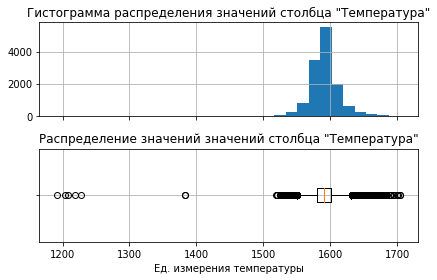

In [40]:
data_plotter(data=data_temp, column_name='Температура', x_label='Ед. измерения температуры')

**Вывод:** обнаружены аномалии – предполачается, что сталь в ковше находится в расплавленном состоянии, при этом диапазон температуры плавления различных марок стали составляет 1350-1530 градусов по Цельсию, а стало быть, измеренные значения являются следствием сбоя датчика температуры

In [41]:
# Отобразим данные с аномально низкой температурой
data_anomaly_temp = data_temp.loc[data_temp['Температура'] < 1500]
data_anomaly_temp

,key,Время замера,Температура
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
8913,1818,2019-07-07 00:30:49,1383.0
8914,1818,2019-07-07 00:31:40,1383.0
10127,2052,2019-07-21 14:51:40,1227.0
12564,2561,2019-08-08 07:34:15,1204.0


In [42]:
# Отобразим время первого и последнего замеров температуры для аномальных партий
temp = data_temp.pivot_table(index='key', values=['Время замера'], aggfunc=['min', 'max'])
temp.columns = ['Время первого замера', 'Время последнего замера']
temp.loc[data_anomaly_temp.key]

,Время первого замера,Время последнего замера
key,,
867,2019-06-04 14:21:00,2019-06-04 14:57:17
1214,2019-06-16 05:32:00,2019-06-16 06:14:45
1619,2019-06-30 11:03:54,2019-06-30 11:21:54
1818,2019-07-07 00:00:14,2019-07-07 00:38:50
1818,2019-07-07 00:00:14,2019-07-07 00:38:50
2052,2019-07-21 14:51:40,2019-07-21 15:24:06
2561,2019-08-08 07:34:15,2019-08-08 07:56:57


**Вывод:** почти во всех случаях аномальная температура выдаётся датчиком во время первого замера, это можно списать на сбой работы датчика и удалить данные из дальнейшего анализа

In [43]:
# Удалим данные с аномально низкой температурой
data_temp.loc[data_temp['Температура'] < 1500, 'Температура'] = -999

In [44]:
data_temp = data_temp.query('`Температура` > 0').reset_index(drop=True)

##### Графическое представление исправленных данных о замеренной температуре

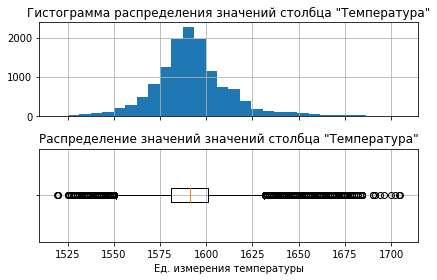

In [45]:
data_plotter(data=data_temp, column_name='Температура', x_label='Ед. измерения температуры')

**Вывод:** аномальных данных не обнаружено

##### Очистка данных от непригодоных для анализа партий

In [46]:
# Оценим количество партий с неменяющейся температурой
temp_df = data_temp.pivot_table(index='key', values=['Температура'], aggfunc=['min', 'max', 'count'])
temp_df.columns = ['Min temp', 'Max temp', 'Count']
temp_df = temp_df.query('`Min temp` == `Max temp`') # .sort_values(by='Count')
temp_df

,Min temp,Max temp,Count
key,,,
195,1583.0,1583.0,1
279,1603.0,1603.0,1
632,1579.0,1579.0,3
2254,1592.0,1592.0,2
2312,1591.0,1591.0,2
...,...,...,...
3237,1569.0,1569.0,1
3238,1584.0,1584.0,1
3239,1598.0,1598.0,1


In [47]:
datas = ['data_arc', 'data_bulk', 'data_bulk_time', 'data_gas', 'data_temp', 'data_wire', 'data_wire']
for data in datas:
    cmd = "{0} = {0}.loc[~{0}['key'].isin(temp_df.index)].reset_index(drop=True)".format(data)
    exec(cmd)  

In [48]:
# Оценка пропусков в данных
data_temp['Температура'].isna().sum()

0

**Вывод:** пропуски были удалены вместе с партиями, в которых температура на датчиках оставалась постоянной

### 2 Подготовка данных для обучения моделей<a id="step2"></a>

**Добавление новых признаков**

***Вычисление длительности нагрева в секундах***

In [49]:
timedelta = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']
seconds_list = [x.seconds for x in timedelta]

data_arc['Время нагрева'] = pd.Series(seconds_list)

***Вычисление отношения активной и реактивной мощностей***

In [50]:
data_arc['Power ratio'] = data_arc['Активная мощность'] / data_arc['Реактивная мощность']

In [51]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Время нагрева,Power ratio
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228,1.420582
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185,1.548395
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172,1.492292
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365,1.561504
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148,1.671717


In [52]:
# Количество оставшихся партий
data_temp.key.unique().size

2472

In [53]:
# Номера оставшихся партий
batch_nums = data_temp.key.unique()

#### Генерация признаков и целевых признаков для обучения и тестирования моделей ML  
Для увеличения информативности обучающей выборки, датасет будет увеличен в длину следующим образом: в качестве наблюдений в рамках одной партии будут создаваться наблюдения между начальной температурой замера и каждой следующей промежуточной вплоть до финальной с описанием состояния стали о количестве нагревов стали дугой, о мощности и длительности нагрева (общее количество полученной энергии), о длительности времени, в течение которого сталь не нагревалась, о времени и длительности между замерами температуры, о среднем соотношении активной и реактивной мощностей, о количестве присыпок и проволок в промежутке между замерами температуры. Также вводится разметка `last` для указания наблюдения, включающего в себя информацию о состоянии стали между начальным и конечным замером температуры в партии

In [54]:
# batches - список обработанных партий
batches = []
for num in tqdm(batch_nums):
    # batch - dataframe с информацией о партии стали
    # Добавление информаци о температуре и времени замера
    batch = data_temp.loc[data_temp.key == num]
    batch.columns = ['key', 'init_time', 'init_temp']
    # Добавление целевого признака (температуры) и времени замера
    shifted_time = pd.DataFrame({'target_time': batch.loc[:, 'init_time'].shift(-1)})
    shifted_temp = pd.DataFrame({'target_temp': batch.loc[:, 'init_temp'].shift(-1)})
    batch = pd.concat([batch, shifted_time, shifted_temp], axis=1)
    # Установка в качестве признака начальной температуры во всех наблюдениях внутри партии стали
    batch.loc[:, 'init_time'] = batch.loc[batch.index[0], 'init_time']
    batch.loc[:, 'init_temp'] = batch.loc[batch.index[0], 'init_temp']
    batch = batch.iloc[:-1]
    
    # Выделение флагом True финальной температуры партии и флагом False всех остальных 
    mark = [False if i != batch.index[-1] else True for i in batch.index]
    mark_df = pd.DataFrame({'last': mark}, index=batch.index)
    batch = pd.concat([batch, mark_df], axis=1)
    
    # Добавление информации о нагреве дугой
    energy_taken = [] # энергия, сообщённая партии стали
    arc_batch = data_arc.loc[data_arc.key == num]
    arcs = pd.DataFrame(
        0,
        columns=['total_time','total_heat_time', 'energy_taken', 'total_downtime', 'heat_count', 'mean_power_ratio'],
        index=batch.index
    )
    
    # Добавление информации о присыпках
    bulk_batch = data_bulk.loc[data_bulk.key == num]
    bulk_batch_time = data_bulk_time.loc[data_bulk_time.key == num]
    bulks = pd.DataFrame(0, columns=data_bulk.columns[1:], index=batch.index)
    if not bulk_batch.empty:
        bulk_cols = {col: False for col in bulks.columns if bulk_batch.loc[bulk_batch.index[0], col] > 0}
    else:
        bulk_cols = {}
    
    # Добавление информации о проводах
    wire_batch = data_wire.loc[data_wire.key == num]
    wire_batch_time = data_wire_time.loc[data_wire_time.key == num]
    wires = pd.DataFrame(0, columns=data_wire.columns[1:], index=batch.index)
    if not wire_batch.empty:
        wire_cols = {col: False for col in wires.columns if wire_batch.loc[wire_batch.index[0], col] > 0}
    else:
        wire_cols = {}
    
    # Расчет информации о нагреве партии стали дугой
    t_measure_0 = batch.loc[batch.index[0], 'init_time'] # время первого замера температуры в партии стали
    for i in batch.index:        
        t_measure_1 = batch.loc[i, 'target_time'] # время текущего замера целевой температуры
        dt = (t_measure_1 - t_measure_0).seconds # длительность интервала между измерениями 
                                                 # температуры внутри одного наблюдения в секундах
        heat_time = [] # список длительности нагревов стали
        power = [] # список активных мощностей во время данных нагревов стали
        power_ratio = [] # список отношений активной мощности к реактивной во время нагревов
        heat_count = 0 # количество нагревов
        j = arc_batch.index[0]
        while j <= arc_batch.index[-1]:
            t_arc_0 = arc_batch.loc[j, 'Начало нагрева дугой'] # время начала нагрева
            t_arc_1 = arc_batch.loc[j, 'Конец нагрева дугой'] # время окончания нагрева
            # если интервал нагрева оказался внутри интервала замера температуры
            if (t_measure_0 <= t_arc_0) and (t_arc_1  <= t_measure_1): 
                heat_time.append(arc_batch.loc[j, 'Время нагрева'])
                power.append(arc_batch.loc[j, 'Активная мощность'])
                power_ratio.append(arc_batch.loc[j, 'Power ratio'])
                heat_count += 1
            # если интервал нагрева своей левой границей оказался вне интервала замера температуры
            elif (t_arc_0 <= t_measure_0) and (t_measure_0 < t_arc_1 < t_measure_1):
                heat_time.append((t_arc_1 - t_measure_0).seconds)
                power.append(arc_batch.loc[j, 'Активная мощность'])
                power_ratio.append(arc_batch.loc[j, 'Power ratio'])
                heat_count += 1
            # если интервал нагрева своей правой границей оказался вне интервала замера температуры
            elif (t_measure_0 < t_arc_0 < t_measure_1) and (t_measure_1 <= t_arc_1):
                heat_time.append((t_measure_1 - t_arc_0).seconds)
                power.append(arc_batch.loc[j, 'Активная мощность'])
                power_ratio.append(arc_batch.loc[j, 'Power ratio'])
                heat_count += 1
            # если интервал нагрева оказался вне интервала замера температуры слева
            elif t_arc_1 < t_measure_0:
                heat_time.append(0)
                power.append(0)
            # если интервал нагрева оказался вне интервала замера температуры слева
            elif t_measure_1 < t_arc_0:
                break # нет смысла дальше перебирать интервалы нагрева
            j += 1
        # вычисление суммарного времени нагрева внутри одного наблюдения
        total_heat_time = np.array(heat_time).sum() 
        # вычисление суммарной полученной сталью энергии внутри одного наблюдения
        energy_taken = np.array(heat_time).dot(np.array(power)) 
        # вычисление суммарного времени остывания стали внутри одного наблюдения
        total_downtime = dt - total_heat_time
        # вычисление среднего отношения активной мощности к реактивной внутри одного наблюдения
        if power_ratio:
            mean_power_ratio = np.array(power_ratio).mean()
        else:
            mean_power_ratio = 0
        arcs.loc[i, 'total_time'] = dt
        arcs.loc[i, 'total_heat_time'] = total_heat_time
        arcs.loc[i, 'energy_taken'] = energy_taken
        arcs.loc[i, 'total_downtime'] = total_downtime
        arcs.loc[i, 'heat_count'] = heat_count
        arcs.loc[i, 'mean_power_ratio'] = mean_power_ratio
        
        # Расчет сыпучих материалов
        for col in bulk_cols:
            if bulk_batch_time[col].notna().tolist()[0] and not bulk_cols[col]:
                bulk_time = bulk_batch_time.loc[bulk_batch_time.index[0], col]
                if bulk_time < t_measure_1:
                    bulks.loc[i:, col] = bulk_batch.loc[bulk_batch.index[0], col]
                    bulk_cols[col] = True
        
        # Расчет проволок  
        for col in wire_cols:
            if wire_batch_time[col].notna().tolist()[0] and not wire_cols[col]:
                wire_time = wire_batch_time.loc[wire_batch_time.index[0], col]
                if wire_time < t_measure_1:
                    wires.loc[i:, col] = wire_batch.loc[wire_batch.index[0], col]
                    wire_cols[col] = True
    
    # добавление всей расчитанной информации
    batch = pd.concat([batch, arcs, bulks, wires], axis=1)
    batches.append(batch)
    
# объединение партий в единый датасет
data_full = pd.concat(batches, axis=0)
data_full = data_full.reset_index(drop=True)

In [55]:
# преобразование типов
for col in ['init_temp', 'target_temp', 'total_heat_time', 'total_downtime']:
    cmd = "data_full['{0}'] = data_full['{0}'].astype(int)".format(col)
    exec(cmd)

In [56]:
# Отображение получившегося датасета
data_full.iloc[:10, :10]

,key,init_time,init_temp,target_time,target_temp,last,total_time,total_heat_time,energy_taken,total_downtime
0,1,2019-05-03 11:16:18,1571,2019-05-03 11:25:53,1604,False,575,365,605.667332,210
1,1,2019-05-03 11:16:18,1571,2019-05-03 11:29:11,1618,False,773,513,708.195035,260
2,1,2019-05-03 11:16:18,1571,2019-05-03 11:30:01,1601,False,823,513,708.195035,310
3,1,2019-05-03 11:16:18,1571,2019-05-03 11:30:39,1613,True,861,513,708.195035,348
4,2,2019-05-03 11:37:27,1581,2019-05-03 11:38:00,1577,False,33,0,0.000000,33
5,2,2019-05-03 11:37:27,1581,2019-05-03 11:49:38,1589,False,731,464,499.975751,267
6,2,2019-05-03 11:37:27,1581,2019-05-03 11:55:50,1604,False,1103,674,673.801792,429
7,2,2019-05-03 11:37:27,1581,2019-05-03 11:58:24,1608,False,1257,674,673.801792,583
8,2,2019-05-03 11:37:27,1581,2019-05-03 11:59:12,1602,True,1305,674,673.801792,631
9,3,2019-05-03 12:13:17,1596,2019-05-03 12:18:36,1597,False,319,124,60.041495,195


Видно, что в качестве температуры первого замера на интервалах всегда указана температура первого замера в партии

**part1 - обучающая+тестовая выборки, полученная в результате раздувания набора данных**

In [57]:
part1 = data_full.loc[~data_full['last']]

**part2 - информация о состоянии стали между начальным и финальным замером температуры в партиях**

In [58]:
part2 = data_full.loc[data_full['last']]

### 3 Обучение и тестрирование моделей ML<a id="step3"></a>

**разбиение part2 на обучающую и тестовую выборки**

In [56]:
train_valid_part2, test = train_test_split(part2, test_size=0.20, random_state=42)

**Оценка корреляции признаков**

In [57]:
pd.concat([part1, train_valid_part2], axis=0).drop(['key', 'init_temp', 'target_temp', 'last'], axis=1).corr()

,total_time,total_heat_time,energy_taken,total_downtime,heat_count,mean_power_ratio,Bulk_1,Bulk_2,Bulk_3,Bulk_4,...,Bulk_15,Wire_1,Wire_2,Wire_3,Wire_4,Wire_5,Wire_6,Wire_7,Wire_8,Wire_9
total_time,1.000000,0.690905,0.589323,0.976727,0.695356,0.226911,0.166570,0.247488,0.091172,0.080164,...,0.180819,0.211995,0.095904,0.127100,0.273749,NaN,0.180407,0.141470,0.003989,0.007749
total_heat_time,0.690905,1.000000,0.889354,0.519764,0.851368,0.415225,0.121539,0.044801,0.164333,0.074530,...,0.320741,0.180446,0.088260,0.050410,0.076755,NaN,0.049594,0.027238,0.018504,-0.014075
energy_taken,0.589323,0.889354,1.000000,0.432550,0.575820,0.315426,0.062001,0.007130,0.101015,0.019482,...,0.300012,0.083044,0.020385,0.008508,0.030596,NaN,0.022292,-0.002743,0.002907,-0.019645
total_downtime,0.976727,0.519764,0.432550,1.000000,0.569121,0.144952,0.160778,0.279166,0.058984,0.072619,...,0.118516,0.196980,0.087146,0.135239,0.300720,NaN,0.198474,0.159095,-0.000776,0.013333
heat_count,0.695356,0.851368,0.575820,0.569121,1.000000,0.440173,0.133748,0.112580,0.205770,0.119473,...,0.245120,0.254304,0.141060,0.102333,0.147041,NaN,0.097370,0.077320,0.041307,-0.014504
mean_power_ratio,0.226911,0.415225,0.315426,0.144952,0.440173,1.000000,0.021906,-0.010270,0.176855,0.119652,...,0.326049,0.260738,0.089315,0.030178,0.005348,NaN,0.025954,-0.002925,0.032154,-0.029566
Bulk_1,0.166570,0.121539,0.062001,0.160778,0.133748,0.021906,1.000000,0.298498,-0.008905,0.042562,...,0.011661,0.005408,0.030229,0.078446,0.216115,NaN,0.217110,0.078076,-0.014045,-0.002599
Bulk_2,0.247488,0.044801,0.007130,0.279166,0.112580,-0.010270,0.298498,1.000000,-0.048734,0.085340,...,-0.115018,-0.147961,-0.042188,0.339055,0.728047,NaN,0.672362,0.388171,-0.004985,-0.008241
Bulk_3,0.091172,0.164333,0.101015,0.058984,0.205770,0.176855,-0.008905,-0.048734,1.000000,-0.178155,...,0.064075,0.160037,0.119962,0.014545,-0.041505,NaN,0.004752,-0.018077,0.009953,-0.005101
Bulk_4,0.080164,0.074530,0.019482,0.072619,0.119473,0.119652,0.042562,0.085340,-0.178155,1.000000,...,0.126107,0.285904,-0.168242,0.004146,0.081785,NaN,0.047127,0.052759,0.015792,-0.044191


**Вывод:** В силу высокой коррелированности можно отбросить следующие признаки: `total_heat_time`. Признак `total_down_time` хоть и коррелирован с другими признаками, удаление его, как показывает дальнейший эксперимент, ухудшает целевую метрику, поэтому принято решение оставить его (его важность обусловлена физическим смыслом: чем больше этот показатель, тем больше остывает сталь)

#### Линейная регрессия

##### Кросс-валидация

In [58]:
# Отбрасываемые признаки
cols_to_drop = ['key', 'init_time', 'target_time', 'target_temp', 'last', 'total_heat_time']

model = LinearRegression()
scores = {'mae': [], 'r2': []}
for train_index, valid_index in KFold(4).split(train_valid_part2):
    train = pd.concat([part1, train_valid_part2.iloc[train_index]], axis=0)
    valid = train_valid_part2.iloc[valid_index]
    features_train = train.drop(cols_to_drop, axis=1)
    features_valid = valid.drop(cols_to_drop, axis=1)
    target_train = train['target_temp']
    target_valid = valid['target_temp']
    model.fit(features_train, target_train)
    predicts = model.predict(features_valid)
    mae = mean_absolute_error(target_valid, predicts)
    r2 = r2_score(target_valid, predicts)
    scores['mae'].append(mae)
    scores['r2'].append(r2)

pprint.pprint(scores)
print('mae:', pd.Series(scores['mae']).mean())
print('r2:', pd.Series(scores['r2']).mean())

{'mae': [7.432998629901968,
         7.561360019922375,
         7.928495942194714,
         7.44627371773584],
 'r2': [0.6061658162869571,
        0.5977525408740401,
        0.5712126003797338,
        0.6534332911555691]}
mae: 7.592282077438725
r2: 0.6071410621740749


##### Тестирование

In [59]:
train = pd.concat([part1, train_valid_part2], axis=0)
features_train = train.drop(cols_to_drop, axis=1)
features_test = test.drop(cols_to_drop, axis=1)
target_train = train['target_temp']
target_test = test['target_temp']

model.fit(features_train, target_train)
predicts = model.predict(features_test)
mae = mean_absolute_error(target_test, predicts)
r2 = r2_score(target_test, predicts)
                   
print('mae:', mae)
print('r2:', r2)

mae: 7.24369863547719
r2: 0.5738016901024148


**Вывод:** Финальная метрика MAE: 7.243.

#### Линейная регрессия с L1-регуляризацией

##### Кросс-валидация

**Best MAE: 7.604676319223658 alpha = 0.1**

##### Тестирование

In [62]:
alpha_best = 0.1

train = pd.concat([part1, train_valid_part2], axis=0)
features_train = train.drop(cols_to_drop, axis=1)
features_test = test.drop(cols_to_drop, axis=1)
target_train = train['target_temp']
target_test = test['target_temp']

model = Lasso(alpha=alpha_best, max_iter=5000, random_state=42)
model.fit(features_train, target_train)
predicts = model.predict(features_test)
mae = mean_absolute_error(target_test, predicts)
r2 = r2_score(target_test, predicts)
                   
print('mae:', mae)
print('r2:', r2)

mae: 7.253166947523834
r2: 0.5726126730544978


**Вывод:** Введение L1-регуляризации не улучшило качество модели

#### LGBMRegressor

##### Кросс-валидация

Отметки о промежуточных показателях при переборе параметров модели  
**best MAE: 4.143636120465429  (num_leaves: 40)**  
**best MAE: 4.6929207798355055 (reg_alpha: 0.69, num_leaves: 35)**  
**best MAE: 4.168393976279727  (r2: 0.8619187792216988, reg_alpha: 0.69, num_leaves: 35, learn_rate: 0.10528268497385247)**

In [67]:
train = pd.concat([part1, train_valid_part2], axis=0)
features_train = train.drop(cols_to_drop, axis=1)
features_test = test.drop(cols_to_drop, axis=1)
target_train = train['target_temp']
target_test = test['target_temp']

parameters = {
        'num_leaves': 35,
        'learning_rate': 0.10528268497385247,
        'n_estimators': 1000,
        'reg_alpha': 0.69,
        'objective': 'mae',
        'force_row_wise': True,
        'silent': False,
        'random_state': 42
    }
model = LGBMRegressor(**parameters)
model.fit(features_train, target_train)
predicts = model.predict(features_test)
mae = mean_absolute_error(target_test, predicts)
r2 = r2_score(target_test, predicts)
                   
print('mae:', mae)
print('r2:', r2)

[LightGBM] [Info] Total Bins 3187
[LightGBM] [Info] Number of data points in the train set: 9285, number of used features: 27
[LightGBM] [Info] Start training from score 1591.000000
mae: 4.146892814134213
r2: 0.8433590647792633


**МАЕ: 4.162**
(к сожалению, при таких параметрах модель обучается очень долго на сервере Яндекс.Практикума, данные показатели качества я получил на локальной машине и скопировал результат в данный отчет)

**График важности фичей**

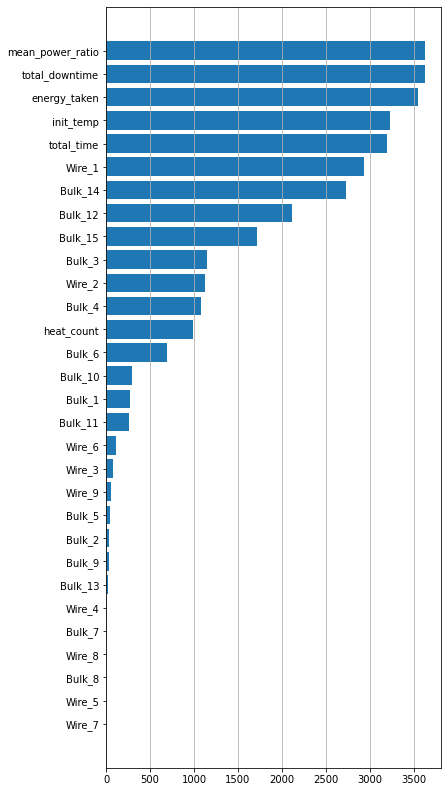

In [63]:
fig, ax = plt.subplots(figsize=(6, 14))
feat_importance_df = pd.DataFrame({'val': model.feature_importances_}, index=model.feature_name_)
feat_importance_df = feat_importance_df.sort_values('val', ascending=True)
ax.barh(feat_importance_df.index, feat_importance_df.val)
ax.grid(True, axis='x')

In [64]:
# Список фичей, представляющих наибольший вклад в результат
important_features = feat_importance_df.index[-17:].tolist()
important_features

['Bulk_11',
 'Bulk_1',
 'Bulk_10',
 'Bulk_6',
 'heat_count',
 'Bulk_4',
 'Wire_2',
 'Bulk_3',
 'Bulk_15',
 'Bulk_12',
 'Bulk_14',
 'Wire_1',
 'total_time',
 'init_temp',
 'energy_taken',
 'total_downtime',
 'mean_power_ratio']

##### Тестирование

In [65]:
train = pd.concat([part1, train_valid_part2], axis=0)
features_train = train.loc[:, important_features]
features_test = test.loc[:, important_features]
target_train = train['target_temp']
target_test = test['target_temp']

parameters = {
        'num_leaves': 35,
        'learning_rate': 0.10528268497385247,
        'n_estimators': 1000,
        'reg_alpha': 0.69,
        'objective': 'mae',
        'force_row_wise': True,
        'silent': False,
        'random_state': 42
    }
model = LGBMRegressor(**parameters)
model.fit(features_train, target_train)
predicts = model.predict(features_test)
mae = mean_absolute_error(target_test, predicts)
r2 = r2_score(target_test, predicts)
                   
print('mae:', mae)
print('r2:', r2)

[LightGBM] [Info] Total Bins 3008
[LightGBM] [Info] Number of data points in the train set: 9285, number of used features: 17
[LightGBM] [Info] Start training from score 1591.000000
mae: 4.08948004723877
r2: 0.8464512308763189


**Вывод:** Финальный МАЕ: 4.089 (результат несколько улучшился после оставления только тех фичей, которые вносят значительный вклад)

### 4 Вывод<a id="step4"></a>

Зачетными показателями качества обладает модель LGBMRegressor (MAE = 4.089), при этом модель обладает высоким коэффициентом детерминации (R2 = 84%)